Source: https://blog.keras.io/building-autoencoders-in-keras.html

In [54]:
from os.path import join
import pandas as pd

import numpy as np
from numpy.random import choice
from numpy.linalg import norm
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from mpl_toolkits.axes_grid1 import make_axes_locatable

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import regularizers
from keras.models import Model, model_from_json
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.datasets import fashion_mnist
from keras import backend as K

from sklearn.preprocessing import minmax_scale
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import pdist, cdist

In [55]:
%matplotlib inline
plt.style.use('ggplot')
n_classes = 10 # all examples have 10 classes
cmap = sns.color_palette('Paired', n_classes)
pd.options.display.float_format = '{:,.2f}'.format

## Fashion MNIST Data

In [56]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [57]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [58]:
image_size = 28     # size of image (pixels per side)
input_size = image_size ** 2 # Compression factor: 784 / 32 = 24.5

In [59]:
class_dict = {0: 'T-shirt/top',
              1: 'Trouser',
              2: 'Pullover',
              3: 'Dress',
              4: 'Coat',
              5: 'Sandal',
              6: 'Shirt',
              7: 'Sneaker',
              8: 'Bag',
              9: 'Ankle boot'}
classes = list(class_dict.keys())

### Plot sample images

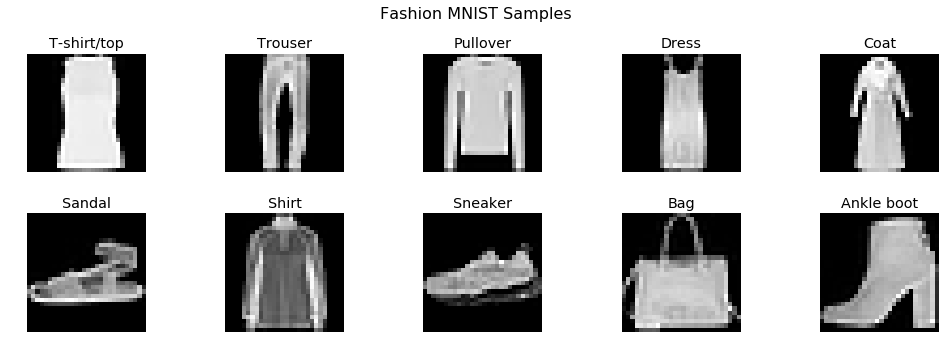

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 5))
axes =axes.flatten()
for row, label in enumerate(classes):
    label_idx = np.argwhere(y_train == label).squeeze()
    axes[row].imshow(X_train[choice(label_idx)], cmap='gray')
    axes[row].axis('off')
    axes[row].set_title(class_dict[row])

fig.suptitle('Fashion MNIST Samples', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.85)

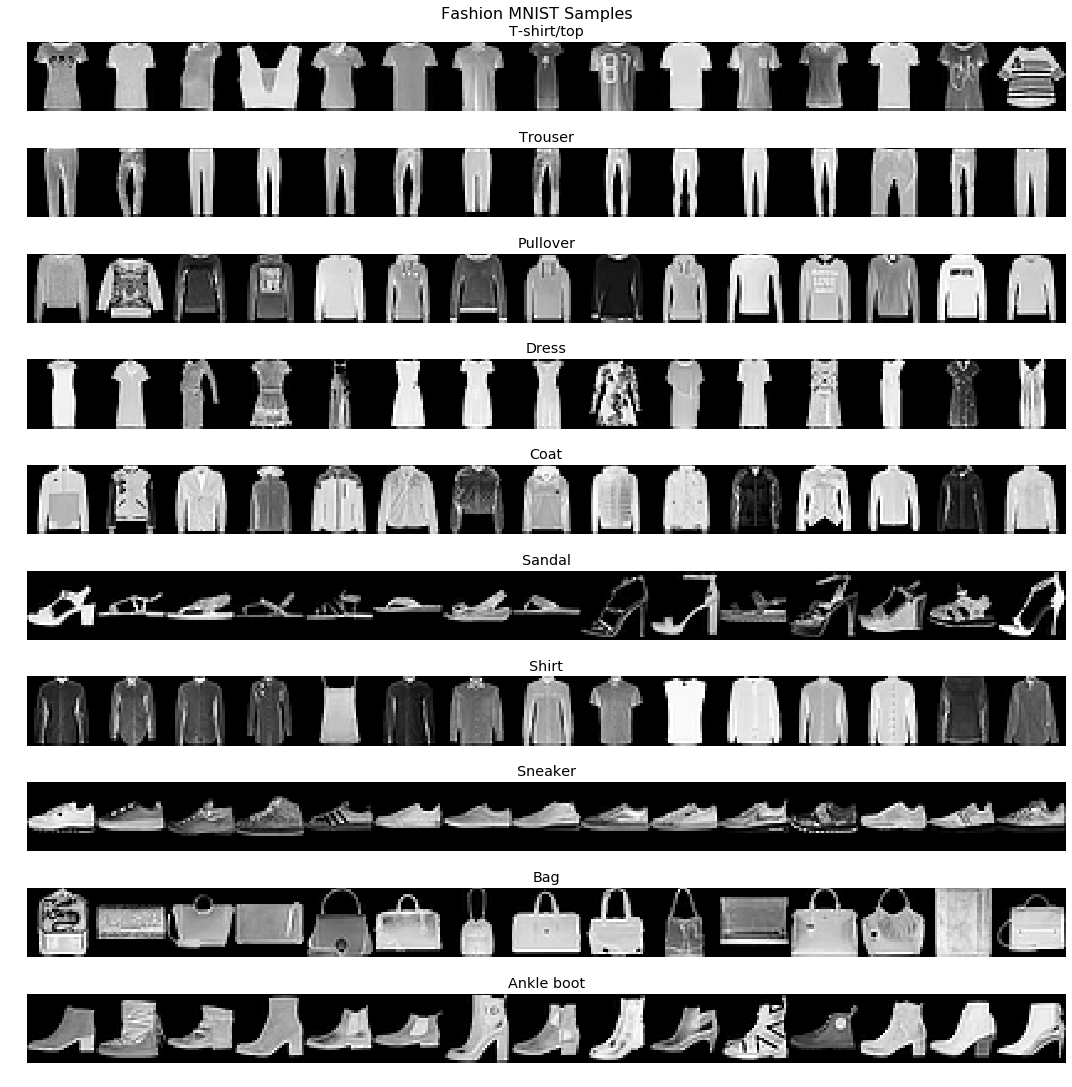

In [8]:
n_samples = 15
fig, axes = plt.subplots(nrows=n_classes, figsize=(15, 15))
axes =axes.flatten()
for row, label in enumerate(classes):
    class_imgs = np.empty(shape=(image_size, n_samples * image_size))
    label_idx = np.argwhere(y_train == label).squeeze()
    class_samples = choice(label_idx, size=n_samples, replace=False)
    for col, sample in enumerate(class_samples):
        i = col * image_size
        class_imgs[:, i:i + image_size] = X_train[sample]
    axes[row].imshow(class_imgs, cmap='gray')
    axes[row].axis('off')
    axes[row].set_title(class_dict[row])

fig.suptitle('Fashion MNIST Samples', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.95, bottom=0)

## Reshape & normalize Fashion MNIST data

In [60]:
encoding_size = 32 # Size of encoding

In [61]:
def data_prep(x, size=input_size):
    return x.reshape(-1, size).astype('float32')/255

In [62]:
X_train_scaled = data_prep(X_train)
X_test_scaled = data_prep(X_test)

In [63]:
X_train_scaled.shape, X_test_scaled.shape

((60000, 784), (10000, 784))

## Vanilla single-layer autoencoder

Encoding 28 x 28 images to a 32 value representation for a compression factor of 24.5

### Single-layer Model

#### Input Layer

In [67]:
input_ = Input(shape=(input_size,), name='Input')

#### Dense Encoding Layer

In [68]:
encoding = Dense(units=encoding_size,
                 activation='relu',
                 name='Encoder')(input_)

#### Dense Reconstruction Layer

In [69]:
decoding = Dense(units=input_size,
                 activation='sigmoid',
                 name='Decoder')(encoding)

#### Autoencoder Model

In [70]:
autoencoder = Model(inputs=input_,
                    outputs=decoding,
                    name='Autoencoder') 

In [71]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 784)               0         
_________________________________________________________________
Encoder (Dense)              (None, 32)                25120     
_________________________________________________________________
Decoder (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


### Encoder Model

In [82]:
encoder = Model(inputs=input_ ,
                outputs=encoding,
                name='Encoder')

In [83]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 784)               0         
_________________________________________________________________
Encoder (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


### Decoder Model

#### Placeholder for encoded input

In [84]:
encoded_input = Input(shape=(encoding_size,), name='Decoder_Input')

#### Extract last autoencoder layer

In [85]:
decoder_layer = autoencoder.layers[-1](encoded_input)

#### Define Decoder Model

In [86]:
decoder = Model(inputs=encoded_input,
                outputs=decoder_layer)

In [87]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Decoder_Input (InputLayer)   (None, 32)                0         
_________________________________________________________________
Decoder (Dense)              (None, 784)               25872     
Total params: 25,872
Trainable params: 25,872
Non-trainable params: 0
_________________________________________________________________


### Compile the Autoencoder Model

In [77]:
autoencoder.compile(optimizer='adam', 
                    loss='mse')

### Train the autoencoder

#### Create `early_stopping` callback

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=1e-5, 
                               patience=5, 
                               verbose=0,
                               restore_best_weights=True,
                               mode='auto')

#### Create TensorBard callback to visualize network performance

In [28]:
tb_callback = TensorBoard(log_dir='logs/autoencoder/mnist/', 
                          histogram_freq=5,
                          write_graph=True, 
                          write_grads=True, 
                          write_images=True)

#### Create checkpoint callback

In [74]:
filepath = 'models/fashion_mnist.autencoder.32.weights.hdf5'

In [29]:
checkpointer = ModelCheckpoint(filepath=filepath, 
                               monitor='val_loss', 
                               verbose=0, 
                               save_best_only=True, 
                               save_weights_only=True, 
                               mode='auto', 
                               period=1)

#### Fit the Model 

To avoid running time, you can load the pre-computed results in the 'model' folder (see below)

In [30]:
autoencoder.fit(x=X_train_scaled,
                y=X_train_scaled,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_split=.1,
                callbacks=[tb_callback, early_stopping, checkpointer])

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 2s 37us/step - loss: 0.0302 - val_loss: 0.0177
Epoch 2/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.0155 - val_loss: 0.0144
Epoch 3/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.0139 - val_loss: 0.0137
Epoch 4/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.0133 - val_loss: 0.0131
Epoch 5/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.0130 - val_loss: 0.0131
Epoch 6/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.0128 - val_loss: 0.0129
Epoch 7/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.0128 - val_loss: 0.0129
Epoch 8/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.0127 - val_loss: 0.0128
Epoch 9/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.0127 - val_loss: 0.01

### Reload weights from best-performing model

In [78]:
autoencoder.load_weights(filepath)

### Evaluate trained model 

In [79]:
mse = autoencoder.evaluate(x=X_test_scaled, y=X_test_scaled)
mse, mse **.5

10000/10000 [==============================] - 0s 13us/step


(0.012588984733819962, 0.11220064497951855)

### Encode and decode test images

In [88]:
encoded_test_img = encoder.predict(X_test_scaled)
encoded_test_img.shape

(10000, 32)

In [89]:
decoded_test_img = decoder.predict(encoded_test_img)
decoded_test_img.shape

(10000, 784)

#### Compare Original with Reconstructed Samples 

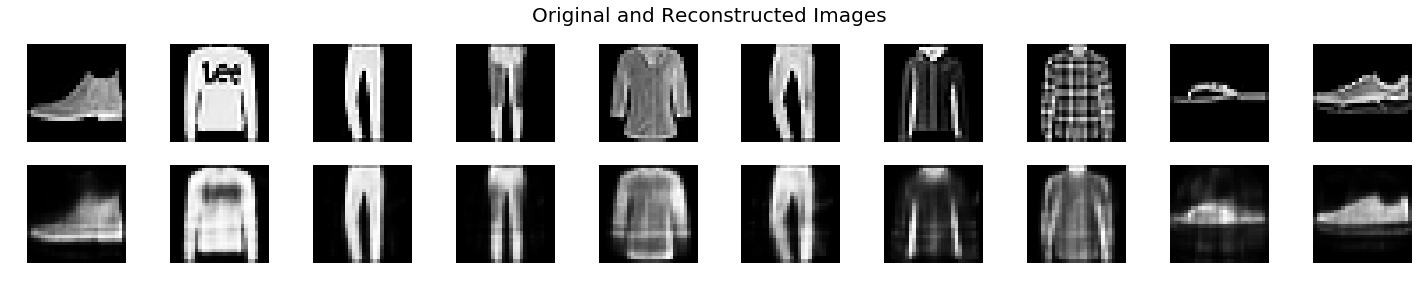

In [95]:
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 4))
for i in range(n_classes):
    
    axes[0, i].imshow(X_test_scaled[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(decoded_test_img[i].reshape(28, 28) , cmap='gray')
    axes[1, i].axis('off')

fig.suptitle('Original and Reconstructed Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig('figures/reconstructed', dpi=300)

## Combine training steps into function

In [131]:
def train_autoencoder(path, model, x_train=X_train_scaled, x_test=X_test_scaled):
    callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
                 ModelCheckpoint(filepath=path, save_best_only=True, save_weights_only=True)]
    model.fit(x=x_train, y=x_train, epochs=100, validation_split=.1, callbacks=callbacks)
    model.load_weights(path)
    mse = model.evaluate(x=x_test, y=x_test)
    return model, mse

## Autoencoders with Sparsity Constraints

### Encoding Layer with L1 activity regularizer

In [78]:
encoding_l1 = Dense(units=encoding_size,
                    activation='relu',
                    activity_regularizer=regularizers.l1(10e-5),
                    name='Encoder_L1')(input_)

### Decoding Layer

In [79]:
decoding_l1 = Dense(units=input_size,
                    activation='sigmoid',
                    name='Decoder_L1')(encoding_l1)

In [80]:
autoencoder_l1 = Model(input_, decoding_l1)

### Autoencoder Model

In [81]:
autoencoder_l1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 784)               0         
_________________________________________________________________
Encoder_L1 (Dense)           (None, 32)                25120     
_________________________________________________________________
Decoder_L1 (Dense)           (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [86]:
autoencoder_l1.compile(optimizer='adam', 
                       loss='mse')

### Encoder & Decoder Models

In [111]:
encoder_l1 = Model(inputs=input_, outputs=encoding_l1, name='Encoder')

In [112]:
encoded_input = Input(shape=(encoding_size,), name='Decoder_Input')
decoder_l1_layer = autoencoder_l1.layers[-1](encoded_input)
decoder_l1 = Model(inputs=encoded_input, outputs=decoder_l1_layer)

### Train Model

In [109]:
path = 'models/fashion_mnist.autencoder_l1.32.weights.hdf5'
autoencoder_l1, mse = train_autoencoder(path, autoencoder_l1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.0870 - val_loss: 0.0873
Epoch 2/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.0870 - val_loss: 0.0873
Epoch 3/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.0870 - val_loss: 0.0873
Epoch 4/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.0870 - val_loss: 0.0873
Epoch 5/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.0870 - val_loss: 0.0873
Epoch 6/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.0870 - val_loss: 0.0873
Epoch 7/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.0870 - val_loss: 0.0873
Epoch 8/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.0870 - val_loss: 0.0873
Epoch 9/100
54000/54000 [==============================] - 2s 36us/step - loss: 0.0870 - val_loss: 0.08

### Evaluate Model

In [110]:
mse

(0.08664910364151, 0.29436219805115943)

In [113]:
encoded_test_img = encoder_l1.predict(X_test_scaled)

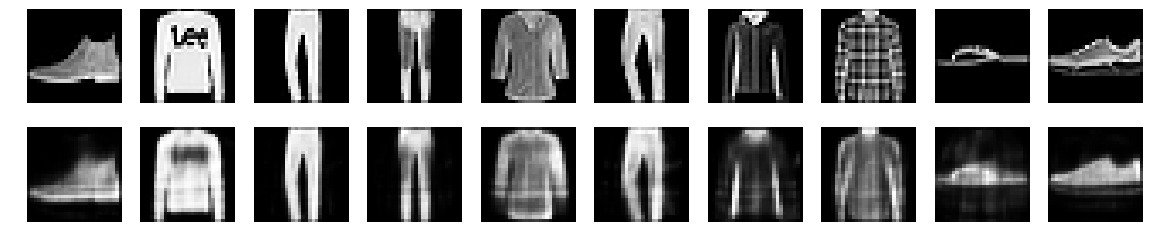

In [114]:
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 4))
for i in range(n_classes):
    
    axes[0, i].imshow(X_test_scaled[i].reshape(img_size, img_size), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(decoded_test_img[i].reshape(28, 28) , cmap='gray')
    axes[1, i].axis('off')

##  Deep Autoencoder

### Define three-layer architecture

In [11]:
input_ = Input(shape=(input_size,))
x = Dense(128, activation='relu', name='Encoding1')(input_)
x = Dense(64, activation='relu', name='Encoding2')(x)
encoding_deep = Dense(32, activation='relu', name='Encoding3')(x)

x = Dense(64, activation='relu', name='Decoding1')(encoding_deep)
x = Dense(128, activation='relu', name='Decoding2')(x)
decoding_deep = Dense(input_size, activation='sigmoid', name='Decoding3')(x)

In [12]:
autoencoder_deep = Model(input_, decoding_deep)
autoencoder_deep.compile(optimizer='adam', loss='mse')

In [13]:
autoencoder_deep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
Encoding1 (Dense)            (None, 128)               100480    
_________________________________________________________________
Encoding2 (Dense)            (None, 64)                8256      
_________________________________________________________________
Encoding3 (Dense)            (None, 32)                2080      
_________________________________________________________________
Decoding1 (Dense)            (None, 64)                2112      
_________________________________________________________________
Decoding2 (Dense)            (None, 128)               8320      
_________________________________________________________________
Decoding3 (Dense)            (None, 784)               101136    
Total para

### Encoder & Decoder Models

In [14]:
encoder_deep = Model(inputs=input_, outputs=encoding_deep, name='Encoder')

In [15]:
encoded_input = Input(shape=(encoding_size,), name='Decoder_Input')

x = autoencoder_deep.layers[-3](encoded_input)
x = autoencoder_deep.layers[-2](x)
decoded = autoencoder_deep.layers[-1](x)

decoder_deep = Model(inputs=encoded_input, outputs=decoded)

In [16]:
decoder_deep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Decoder_Input (InputLayer)   (None, 32)                0         
_________________________________________________________________
Decoding1 (Dense)            (None, 64)                2112      
_________________________________________________________________
Decoding2 (Dense)            (None, 128)               8320      
_________________________________________________________________
Decoding3 (Dense)            (None, 784)               101136    
Total params: 111,568
Trainable params: 111,568
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [17]:
path = 'models/fashion_mnist.autencoder_deep.32.weights.hdf5'

In [180]:
autoencoder_deep, mse = train_autoencoder(path, autoencoder_deep)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 4s 67us/step - loss: 0.0093 - val_loss: 0.0096
Epoch 2/100
54000/54000 [==============================] - 3s 58us/step - loss: 0.0093 - val_loss: 0.0095
Epoch 3/100
54000/54000 [==============================] - 3s 59us/step - loss: 0.0092 - val_loss: 0.0096
Epoch 4/100
54000/54000 [==============================] - 3s 58us/step - loss: 0.0092 - val_loss: 0.0096
Epoch 5/100
54000/54000 [==============================] - 3s 59us/step - loss: 0.0092 - val_loss: 0.0094
Epoch 6/100
54000/54000 [==============================] - 3s 59us/step - loss: 0.0092 - val_loss: 0.0095
Epoch 7/100
54000/54000 [==============================] - 3s 58us/step - loss: 0.0092 - val_loss: 0.0095
Epoch 8/100
54000/54000 [==============================] - 3s 58us/step - loss: 0.0092 - val_loss: 0.0095
Epoch 9/100
54000/54000 [==============================] - 3s 59us/step - loss: 0.0092 - val_loss: 0.00

In [18]:
autoencoder_deep.load_weights(path)

### Evaluate Model

In [181]:
mse, mse**.5

(0.009365755455195903, 0.09677683325670407)

In [19]:
reconstructed_images = autoencoder_deep.predict(X_test_scaled)
reconstructed_images.shape

(10000, 784)

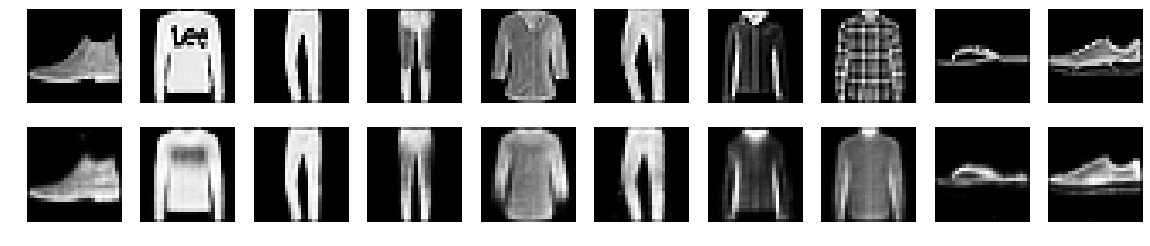

In [21]:
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 4))
for i in range(n_classes):
    
    axes[0, i].imshow(X_test_scaled[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_images[i].reshape(image_size, image_size) , cmap='gray')
    axes[1, i].axis('off')

### Compute t-SNE Embedding

Since t-SNE can take a long time to run, we are providing pre-computed results

In [22]:
# alternatively, compute the result yourself
tsne = TSNE(perplexity=25, n_iter=5000)
train_embed = tsne.fit_transform(encoder_deep.predict(X_train_scaled))

#### Persist result

In [28]:
# store results given computational intensity (different location to avoid overwriting the pre-computed results)
# pd.DataFrame(train_embed).to_hdf('tsne.h5', 'autoencoder_deep')

#### Load pre-computed embeddings

In [ ]:
# Load the pre-computed results here:
# train_embed = pd.read_hdf('tsne.h5', 'autoencoder_deep')

#### Visualize Embedding

In [38]:
def plot_embedding(X, y=y_train, title=None, min_dist=0.1, n_classes=10, cmap=cmap):
    X = minmax_scale(X)
    inner = outer = 0
    for c in range(n_classes):
        inner += np.mean(pdist(X[y == c]))
        outer += np.mean(cdist(X[y == c], X[y != c]))
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.axis('off')
    ax.set_title(title + ' | Distance: {:.2%}'.format(inner/outer))
    sc = ax.scatter(*X.T, c=y, cmap=ListedColormap(cmap), s=5);
    shown_images = np.ones((1, 2))
    images = X_train.reshape(-1, 28, 28)
    for i in range(0, X.shape[0]):
        dist = norm(X[i] - shown_images, axis=1)
        if (dist > min_dist).all():
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = AnnotationBbox(OffsetImage(images[i], cmap=plt.cm.gray_r), X[i])
            ax.add_artist(imagebox)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(sc, cax=cax)
    fig.tight_layout()
    fig.savefig('figures/tsne_autoencoder_deep', dpi=300)

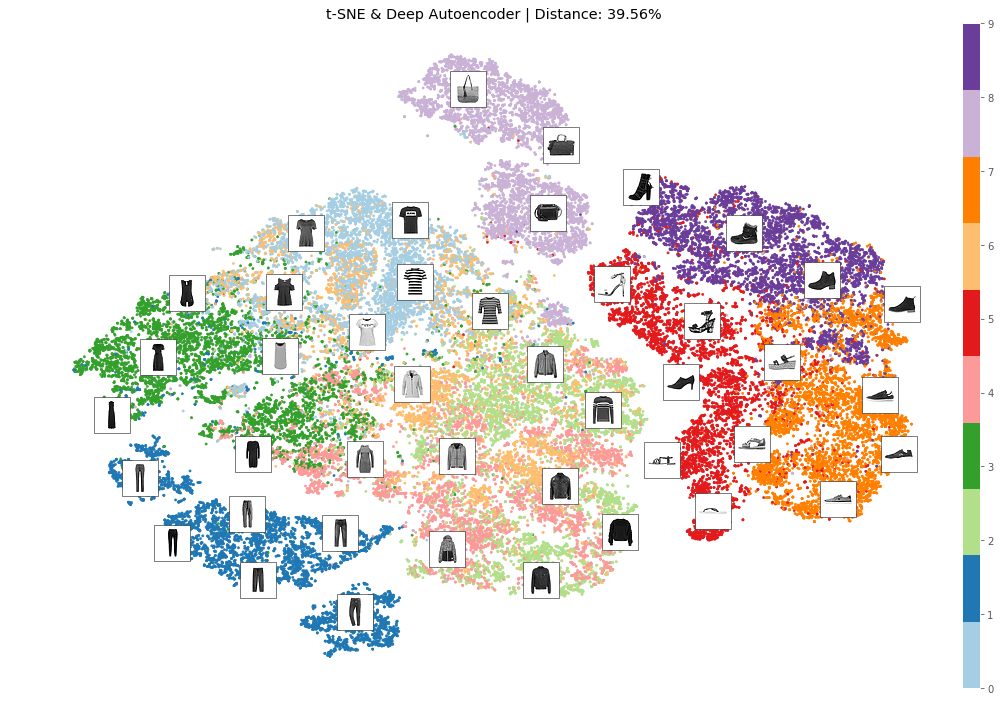

In [39]:
plot_embedding(X=train_embed, title='t-SNE & Deep Autoencoder')